In [1]:
import numpy as np
import torch
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian
import matplotlib.pyplot as plt
from bmadx.track import *
tkwargs = {
    "dtype" : torch.double
}
import time
np.set_printoptions(precision= 16, suppress=False)
torch.set_printoptions(precision= 16, sci_mode=True)
torch.__version__, np.__version__
%config InlineBackend.figure_format = 'retina'

In [2]:
c_light = 2.99792458e8 #speed of light in m/s
m_e = 0.510998950e6 #electron mass in eV

In [3]:
def torchquadrupole(L: torch.Tensor, K1: torch.Tensor, NUM_STEPS=1,
                    X_OFFSET: torch.Tensor=torch.tensor(0.0,**tkwargs),
                    Y_OFFSET: torch.Tensor=torch.tensor(0.0,**tkwargs),
                    TILT: torch.Tensor=torch.tensor(0.0,**tkwargs)):
    return Quadrupole(L=L, K1=K1, NUM_STEPS=NUM_STEPS, X_OFFSET=X_OFFSET,
                     Y_OFFSET=Y_OFFSET, TILT=TILT)

# Quad strength optimization

In [4]:
s = 0.0 # initial s
p0c = 4.0E+07 # Reference particle momentum in eV
mc2 = 1*m_e # electron mass in eV
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs)

# Initial beam distribution
sample_size = 1000
mean = torch.zeros(6, **tkwargs)
cov = torch.diag(torch.tensor([1e-6, 2e-6, 1e-6, 2e-6, 1e-6, 2e-6],**tkwargs))
torch.manual_seed(0)
dist = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
sample = dist.sample(torch.Size([sample_size]))
p_in = Particle(*sample.T, ts, tp0c, tmc2)

In [5]:
# Objective function (O.F.)
def beamsize(k1s:torch.Tensor):
    """Returns sqrt(std(x)**2 + std(y)**2) after lattice composed by len(k1s)+1
    drifts with len(k1s) quadrupoles in between.
    """
    # Lattice fixed parameters
    L_d = 1.00 # Drift length
    L_q = 0.1 # Quad length 
    drift = Drift(L=L_d)
    lattice = [drift]
    for k1 in k1s:
        lattice.append( torchquadrupole(L=L_q, K1=k1) )
        lattice.append( drift )
    p_out = track_a_lattice(p_in, lattice)[-1]
    return torch.sqrt(torch.std(p_out.x)**2+torch.std(p_out.y)**2)

# Model to optimize using torch.nn.Module
class BeamSizeModel(torch.nn.Module):
    """Beam size torch module."""
    def __init__(self, k1s):
        super().__init__()
        self.register_parameter('k1s',torch.nn.Parameter(k1s))
    def forward(self):
        return beamsize(self.k1s) + torch.abs(torch.mean(self.k1s))*1e-3  # O.F.

In [6]:
def train_model(model, training_iter, alpha=0.1):
    history_param = [None] * training_iter
    history_loss = [None] * training_iter
    # print the trainable parameters
    for param in model.named_parameters():
        print(f'{param[0]} : {param[1]}')
    
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), alpha)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Calc loss and backprop gradients
        loss = model()  # loss is just O.F.
        loss.backward()
        if i%100==0: #print each 10 steps
            print('Iter %d/%d - Loss: %.5f '% (
                i + 1, training_iter, loss.item()
            ))
        for param in model.parameters():
            history_param[i] = param.data.detach().numpy().copy()
        history_loss[i] = loss.detach().numpy().copy()
        optimizer.step()
        

    return np.asarray(history_param), np.asarray(history_loss)

In [7]:
%%time
# Initial k1s
k1s = torch.zeros(10, **tkwargs)

# Optimization
model = BeamSizeModel(k1s)
params, loss = train_model(model, 2000)

k1s : Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64,
       requires_grad=True)
Iter 1/2000 - Loss: 0.02364 
Iter 101/2000 - Loss: 0.00184 
Iter 201/2000 - Loss: 0.00116 
Iter 301/2000 - Loss: 0.00103 
Iter 401/2000 - Loss: 0.00093 
Iter 501/2000 - Loss: 0.00085 
Iter 601/2000 - Loss: 0.00078 
Iter 701/2000 - Loss: 0.00069 
Iter 801/2000 - Loss: 0.00062 
Iter 901/2000 - Loss: 0.00057 
Iter 1001/2000 - Loss: 0.00053 
Iter 1101/2000 - Loss: 0.00049 
Iter 1201/2000 - Loss: 0.00048 
Iter 1301/2000 - Loss: 0.00046 
Iter 1401/2000 - Loss: 0.00046 
Iter 1501/2000 - Loss: 0.00044 
Iter 1601/2000 - Loss: 0.00045 
Iter 1701/2000 - Loss: 0.00042 
Iter 1801/2000 - Loss: 0.00042 
Iter 1901/2000 - Loss: 0.00041 
CPU times: user 1min 14s, sys: 0 ns, total: 1min 14s
Wall time: 1min 45s


Text(0, 0.5, 'loss $\\sqrt{\\sigma_x^2+\\sigma_y^2}$ (mm)')

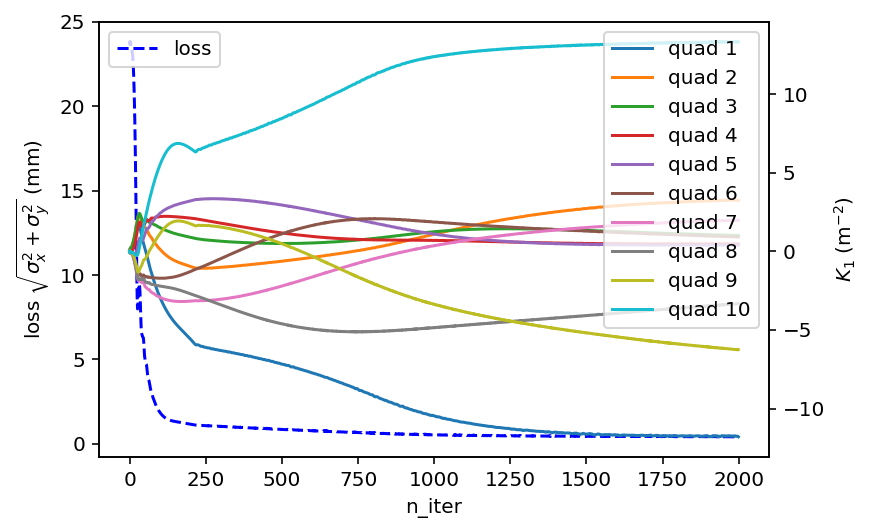

In [8]:
# Plot O.F. and parameters as function of iteration number
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for i in range(len(k1s)):
    ax2.plot(np.arange(len(params[:,0])), params[:,i], label='quad '+str(i+1))
ax1.plot(np.arange(len(loss)), loss*1000, '--b', label='loss')
ax2.legend()
ax1.legend(loc=2)
ax1.set_xlabel('n_iter')
ax2.set_ylabel(r'$K_1$ (m$ ^{-2}$)')
ax1.set_ylabel(r'loss $\sqrt{\sigma_x^2+\sigma_y^2}$ (mm)')
#plt.savefig("10quadopt.eps")

#params, loss

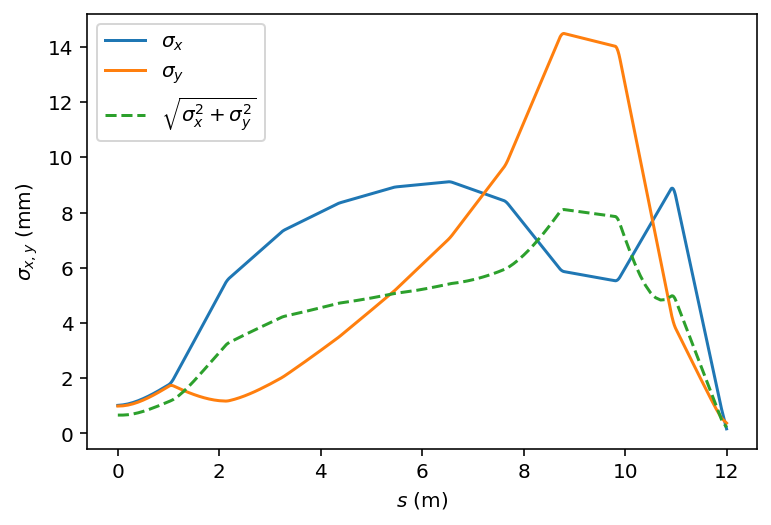

In [9]:
# plot beamsize for final config
# Lattice fixed parameters
L_d = 1.00 # Drift length
L_q = 0.1 # Quad length 
drift = Drift(L=L_d)
lattice = [drift]
lattice = [drift]
k1s = torch.tensor(params[-1], **tkwargs)
for k1 in k1s:
    lattice.append( torchquadrupole(L=torch.tensor(L_q, **tkwargs), K1=k1) )
    lattice.append( drift )
n=10
stubbed_lattice = stub_lattice(lattice, n)
all_p = track_a_lattice(p_in, stubbed_lattice)
stdx, stdy, stdr, s = [torch.std(par.x) for par in all_p], [torch.std(par.y) for par in all_p], [torch.std(torch.sqrt(par.x**2+par.y**2)) for par in all_p], [par.s for par in all_p]
plt.plot(s, np.array(stdx)*1000, label=r'$\sigma_x$')
plt.plot(s, np.array(stdy)*1000, label=r'$\sigma_y$')
plt.plot(s, np.array(stdr)*1000, '--', label=r'$\sqrt{\sigma_x^2 + \sigma_y^2}$')
plt.xlabel(r'$s$ (m)')
plt.ylabel(r'$\sigma_{x,y}$ (mm)')
plt.legend()
#plt.savefig("10quadopt_s.eps")